In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import CubicSpline, interp1d
from scipy.optimize import curve_fit

# Extraccion y manipulación de datos

In [52]:
def plot_full_cold_hot(T,L):
    df_cold = pd.read_csv(f'./Datos/Ising/ising_2d_cold_t{T:.2f}_{L}.csv')
    x = df_cold["sweep"]
    y_cold_tot = df_cold["H"]
    y_cold_term = df_cold["H_t"].dropna()

    df_hot = pd.read_csv(f'./Datos/Ising/ising_2d_hot_t{T:.2f}_{L}.csv')
    y_hot_tot = df_hot["H"]
    y_hot_term = df_hot["H_t"].dropna()


    y_cold_tot = y_cold_tot/L**2 # Normalizamos la energía por sitio
    y_hot_tot = y_hot_tot/L**2
    y_cold_term = y_cold_term/L**2 # Normalizamos la energía por sitio
    y_hot_term = y_hot_term/L**2
    
    mean_cold = y_cold_term.mean()
    err_cold = np.sqrt(y_cold_term.var() / len(y_cold_term))

    mean_hot = y_hot_term.mean()
    err_hot = np.sqrt(y_hot_term.var() / len(y_hot_term))

    min=-2
    
    plt.figure(figsize=(20,5))

    plt.plot(x,y_cold_tot,ls="-",marker="o",label=f"Cold mean:{round(mean_cold,3)}$\\pm$ {round(err_cold,3)}")#cold
    plt.plot(x,y_hot_tot,ls="-",marker="o",label=f"Hot mean:{round(mean_hot,3)}$\\pm${round(err_hot,3)}")#hot

    plt.xlabel('Sweep')
    plt.ylabel('$<H> / V$')
    plt.title('Ising model 2D\n L=%d, T=%1.1f'%(L,T))

    plt.axhline(y=-2, color='k',label="$H_{min}$ / V = -2")

    plt.axhline(y=mean_cold, color='r')
    plt.axhline(y=mean_hot, color='b')

    plt.legend()

    plt.show()

$$ [ s_1,s_2,...,s_n]$$

para $i \in [1,...,n]$ $[s_1,s_2,...,s_{i-1},s_{i+1},...,s_n]$

var = $(n-1)(<\bar{x}-x_{jac}>)$

stderr = $\sqrt{var/n}$

In [2]:
def jackknife_error(data,L):
    n = len(data)
    jackknife_means = np.zeros(n)
    jackknife_means2 = np.zeros(n)
    cv_values = np.zeros(n)
    for i in range(n):
        jackknife_sample = np.delete(data, i)
        jackknife_means[i] = np.mean(jackknife_sample)
        jackknife_means2[i] = np.mean(jackknife_sample ** 2)
        cv_values[i] = (jackknife_means2[i] - jackknife_means[i] ** 2)/L**2
    
    jackknife_mean = np.mean(cv_values)
    jackknife_var = (n - 1) * np.mean((cv_values - jackknife_mean) ** 2)
    jackknife_se = np.sqrt(jackknife_var / n)
    
    return jackknife_se

In [3]:
def info_dict(T,L,start = "hot"):

    df = pd.read_csv(f'./Datos/Ising/ising_2d_hot_t{T:.2f}_{L}.csv') if start=="hot" else pd.read_csv(f'./Datos/Ising/ising_2d_cold_t{T:.2f}_{L}.csv')
    H = df["H_t"].dropna()
    M = df["M_t"].dropna()
    
    mean_H = H.mean()
    stderr_H = np.sqrt(H.var()/len(H))
    mean_H2 = (H**2).mean()

    mean_M = M.mean()
    stderr_M = np.sqrt(M.var()/len(M))/L**2
    mean_M2 = (M**2).mean()

    Cv = (mean_H2 - mean_H**2)/L**2
    stderr_cv = ((H - mean_H)**2).mean()/L**2
    #stderr_cv = jackknife_error(H,L)

    m = M.abs().mean()/L**2
    stderr_m = np.sqrt(M.abs().var()/len(M))/L**2

    chi_m = (mean_M2 - (M.abs().mean())**2)/L**2
    stderr_chi = ((M-M.abs().mean())**2).mean()/L**2
    
    dic = {"H":mean_H/L**2,"stderr_H":stderr_H/L**2,
           "M":mean_M/L**2,"stderr_M":stderr_M/L**2,
           "Cv":Cv,"stderr_cv":stderr_cv,
           "chi_m":chi_m,"stderr_chi":stderr_chi,
           "m":m,"stderr_m":stderr_m}
    return dic

In [4]:
def L_arrays(L,T_min = 1.5,T_max = 3.8):

    fine_T_min = 2.1
    fine_T_max = 2.4
    fine_step = 0.03

    T_values1 = np.arange(T_min,fine_T_min,0.1).round(2)
    T_values2 = np.arange(fine_T_min,fine_T_max+fine_step,fine_step).round(2)
    T_values3 = np.arange(fine_T_max+0.1,T_max+0.1,0.1).round(2)

    T_values = np.concatenate((T_values1,T_values2,T_values3))
    T_values = np.unique(T_values)
    
    H = np.zeros(len(T_values))
    stderr_H = np.zeros(len(T_values))

    M = np.zeros(len(T_values))
    stderr_M = np.zeros(len(T_values))
    
    Cv = np.zeros(len(T_values))
    stderr_cv = np.zeros(len(T_values))

    chi_m = np.zeros(len(T_values))
    stderr_chi = np.zeros(len(T_values))

    m = np.zeros(len(T_values))
    stderr_m = np.zeros(len(T_values))

    for i,T in enumerate(T_values):
        dic = info_dict(T,L)

        H[i] = dic["H"]
        stderr_H[i] = dic["stderr_H"]

        M[i] = dic["M"] 
        stderr_M[i] = dic["stderr_M"]

        Cv[i] = dic["Cv"]
        stderr_cv[i] = dic["stderr_cv"]

        chi_m[i] = dic["chi_m"]
        stderr_chi[i] = dic["stderr_chi"]
        
        m[i] = dic["m"]
        stderr_m[i] = dic["stderr_m"]

    #stderr_cv = jackknife_error(Cv)
    
    return {"T":T_values,
            "H":H,"stderr_H":stderr_H,
            "M":M,"stderr_M":stderr_M,
            "Cv":Cv,"stderr_cv":stderr_cv,
            "chi_m":chi_m,"stderr_chi":stderr_chi,
            "m":m,"stderr_m":stderr_m}


In [5]:
def interp_quad_max(x,y):
    max_ind = y.argmax()
    yl = [y[max_ind-1],y[max_ind],y[max_ind+1]]
    xl = [x[max_ind-1],x[max_ind],x[max_ind+1]]

    x_inter=np.linspace(x[max_ind-1],x[max_ind+1],num=1000)
    inter = CubicSpline(xl,yl)
    y_inter = inter(x_inter)

    x_max = x_inter[y_inter.argmax()]
    y_max = y_inter[y_inter.argmax()]
    return x_max,y_max

In [6]:
def adjust(x,y,ansatz,yerr=0.01):

    params, covariance = curve_fit(ansatz, x, y,sigma=yerr)

    residuals = (y - ansatz(x, *params))/yerr
    chi_squared = np.sum(residuals**2)

    # Calcula el número de grados de libertad
    num_params = len(params)
    num_data_points = len(y)
    degrees_of_freedom = num_data_points - num_params

    # Calcula el chi-cuadrado reducido
    reduced_chi_squared = chi_squared / degrees_of_freedom

    return {"params":params,"vars":np.diag(covariance),"chi":reduced_chi_squared}

# Comparación de energías, Hot start vs Cold start

In [ ]:
T_values=[2.1,3.8]

for T in T_values:
    plot_full_cold_hot(T=round(T, 1), L=16)

# Cantidades físicas

## Densidad de energía y temperatura  ($\frac{<H>}{V}$ vs T)

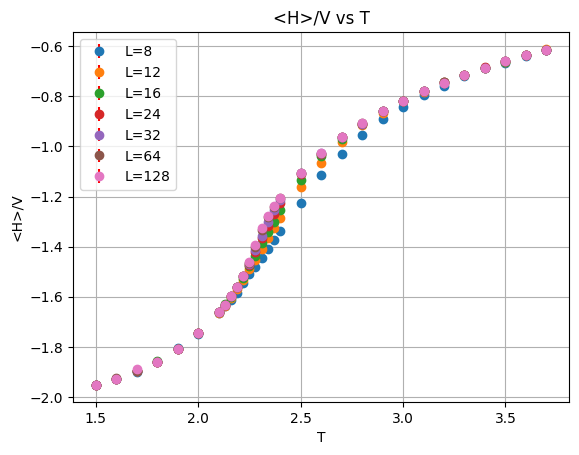

In [26]:
L_values = [8,12,16,24,32,64,128][:]

T_i = 1.5
T_f = 3.8

plt.title("<H>/V vs T")
plt.grid()
plt.xlabel("T")
plt.ylabel("<H>/V")

for L in L_values:
    dic = L_arrays(L)

    x = dic["T"].tolist()
    t_i = x.index(T_i)
    t_f = x.index(T_f)

    y = dic["H"]
    yerr = dic["stderr_H"]

    if t_i == t_f:
        plt.errorbar(x[t_i],y[t_i],yerr[t_i],marker="o",ls="",ecolor="r",label=f"{L=}")
    else:
        plt.errorbar(x[t_i:t_f],y[t_i:t_f],yerr[t_i:t_f],marker="o",ls="",ecolor="r",label=f"{L=}")

plt.legend()
plt.show()

## Capacidad calorífica y temperatura ($C_v$ vs $T$)

$$C_v = (<H²>-<H>²)\frac{1}{V}$$

$$err = <(H-<H>)²>\frac{1}{V} $$

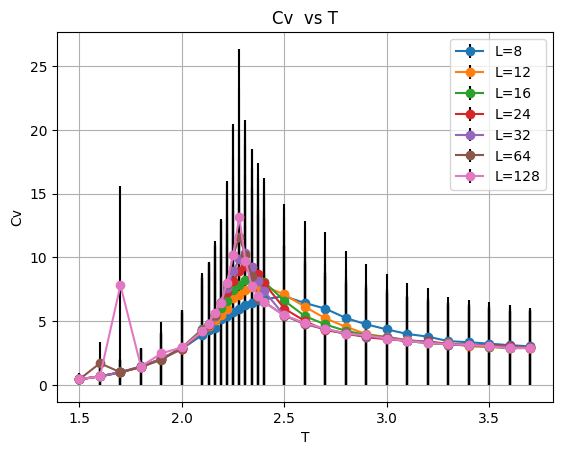

[2.48  2.409 2.34  2.32  2.304 2.28  2.279]
Tc = 2.345, err = 0.026


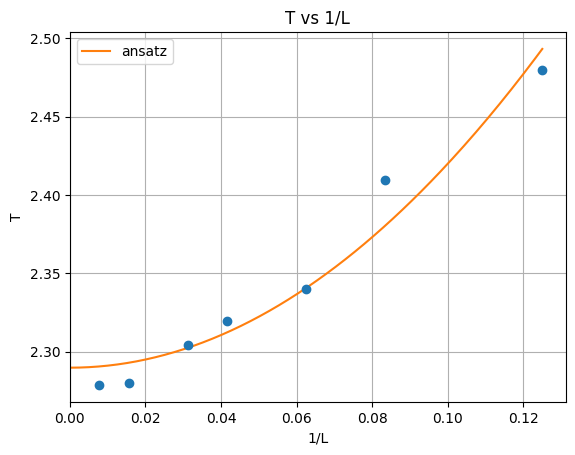

{'params': array([13.02300399,  2.28977257]),
 'vars': array([1.48864846e+00, 6.62779925e-05]),
 'chi': 2.789560396809105}

In [28]:
L_values = np.array([8,12,16,24,32,64,128])[:]

T_i = 1.5
T_f = 3.8

plt.title("Cv  vs T")
plt.grid()
plt.xlabel("T")
plt.ylabel("Cv")

cvmax=[]
Tc = []
for L in L_values:
    dic = L_arrays(L)
    
    x = dic["T"].tolist()
    t_i = x.index(T_i)
    t_f = x.index(T_f)
    x = x[t_i:t_f]

    y = dic["Cv"]
    y = y[t_i:t_f]
    
    yerr = dic["stderr_cv"]
    yerr = yerr[t_i:t_f]
    #yerr = np.zeros(len(x))
    
    cvmax+=[interp_quad_max(x,y)[1]]
    Tc+=[interp_quad_max(x,y)[0]]

    plt.errorbar(x,y,yerr,marker="o",ls="-",ecolor="k",label=f"{L=}")

plt.legend()
plt.show()

cvmax = np.array(cvmax)
Tc = np.array(Tc)

print(f"{Tc.round(3)}")
print("Tc = %0.3f, err = %0.3f"%(Tc.mean(),np.sqrt(Tc.var()/len(Tc))))

#extrapolacion

def ansatz(x,a,b):
    return a*x**2+b

xans = np.linspace(0,(1/L_values).max(),200)

dic = adjust(1/L_values,Tc,ansatz=ansatz)


plt.errorbar(1/L_values,Tc,ls="",marker="o")
plt.plot(xans,ansatz(xans,*dic["params"]),label = "ansatz")

plt.xlim(xans.min(),xans.max()+.05*xans.max())
plt.title("T vs 1/L")
plt.ylabel("T")
plt.xlabel("1/L")
plt.legend()
plt.grid()
plt.show()

dic

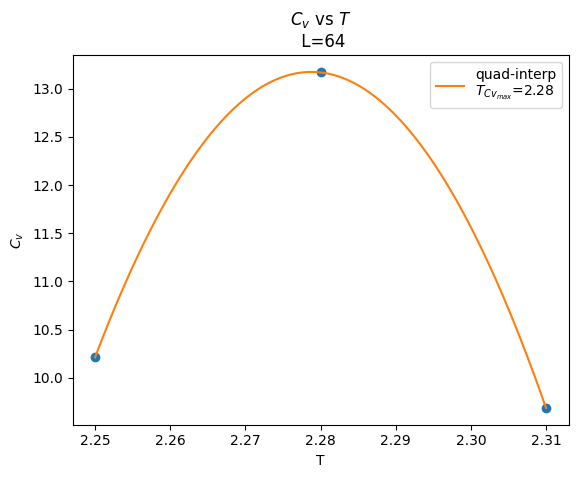

Tc=2.278768768768769 , cv_max=13.1754458853334


In [41]:
max_ind = y.argmax()
yl = [y[max_ind-1],y[max_ind],y[max_ind+1]]
xl = [x[max_ind-1],x[max_ind],x[max_ind+1]]

x_inter=np.linspace(x[max_ind-1],x[max_ind+1],num=1000)
inter = CubicSpline(xl,yl)
y_inter = inter(x_inter)

Tc = x_inter[y_inter.argmax()]
cv_max = y_inter[y_inter.argmax()]

plt.plot(xl,yl,marker="o",ls="")
plt.plot(x_inter,y_inter,label="quad-interp\n$T_{Cv_{max}}$=%.2f"%Tc)
plt.title("$C_v$ vs $T$\n L=64")
plt.ylabel("$C_v$")
plt.xlabel("T")
plt.legend()
plt.show()

print(f"{Tc=} , {cv_max=}")

## Magnetización vs T ($M$ vs $T$)

$$ M=\sum_{x,y}s_{x,y}$$

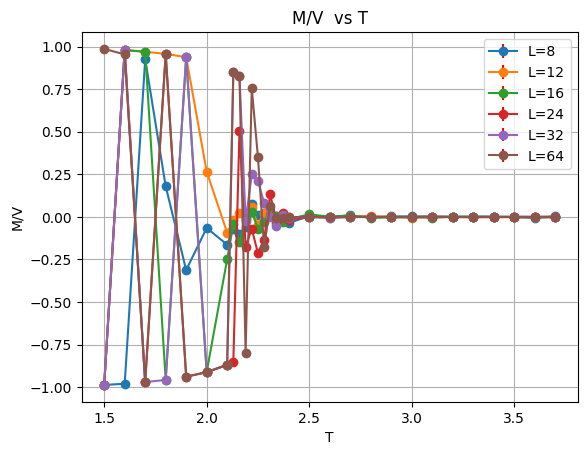

In [23]:
L_values = [8,12,16,24,32,64,128][:-1]

T_i = 1.5
T_f = 3.8

plt.title("M/V  vs T")
plt.grid()
plt.xlabel("T")
plt.ylabel("M/V")

for L in L_values:
    dic = L_arrays(L)
    
    x = dic["T"].tolist()
    t_i = x.index(T_i)
    t_f = x.index(T_f)

    y = dic["M"]
    yerr = dic["stderr_M"]
    

    plt.errorbar(x[t_i:t_f],y[t_i:t_f],yerr[t_i:t_f],marker="o",ls="-",ecolor="r",label=f"{L=}")

plt.legend()
plt.show()

## Densidad de magnetización vs T ($m$ vs $T$)

$$m=\frac{1}{V}<|M|>$$

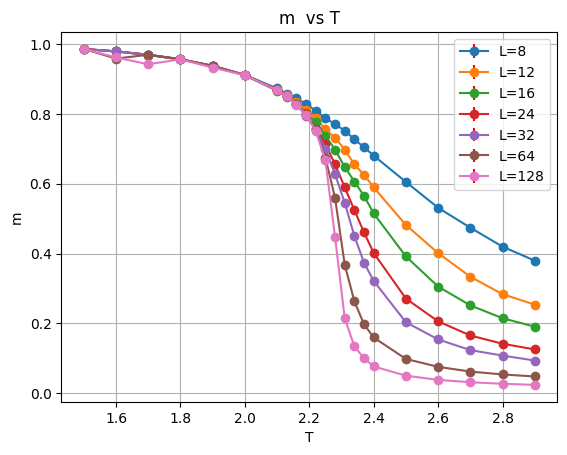

In [22]:
L_values = [8,12,16,24,32,64,128][:]

T_i = 1.5
T_f = 3.0

plt.title("m  vs T")
plt.grid()
plt.xlabel("T")
plt.ylabel("m")

for L in L_values:
    dic = L_arrays(L)
    x = dic["T"].tolist()
    t_i = x.index(T_i)
    t_f = x.index(T_f)
    
    y = dic["m"]
    yerr = dic["stderr_m"]
   

    plt.errorbar(x[t_i:t_f],y[t_i:t_f],yerr[t_i:t_f],marker="o",ls="-",ecolor="r",label=f"{L=}")

plt.legend()
plt.show()

## Suceptibilidad magnética vs T ($\chi_m$ vs $T$)

$$ \chi_m = (<M²>-<|M|>²)\frac{1}{V} $$

$$ err = <(M - <|M|>)²>\frac{1}{V}$$

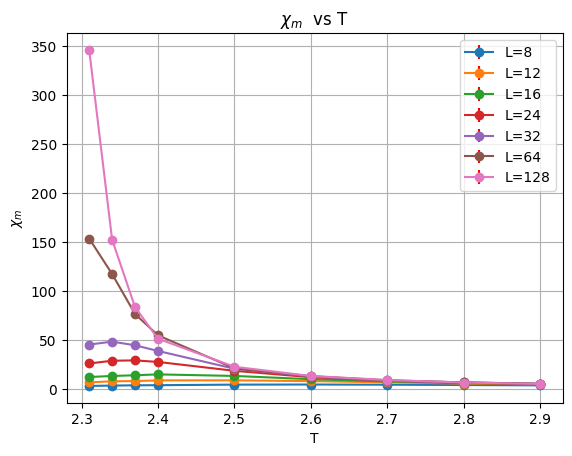

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 800.

In [21]:
L_values = [8,12,16,24,32,64,128][:]

T_i = 2.31
T_f = 3.0

plt.title("$\\chi_m$  vs T")
plt.grid()
plt.xlabel("T")
plt.ylabel("$\\chi_m$")



for L in L_values[:]:
    dic = L_arrays(L)
    x = dic["T"].tolist()
    t_i = x.index(T_i)
    t_f = x.index(T_f)

    y = dic["chi_m"]
    yerr = dic["stderr_chi"]
    yerr = np.zeros(len(x))

    plt.errorbar(x[t_i:t_f],y[t_i:t_f],yerr[t_i:t_f],marker="o",ls="-",ecolor="r",label=f"{L=}")

plt.legend()
plt.show()


#extrapol

def ansatz(x,a,b,c):
    return a*np.abs(x-b)**c

dic_adj = adjust(x[t_i:t_f],y[t_i:t_f],ansatz)

xans = np.linspace(min(x[t_i:t_f]),max(x[t_i:t_f]),200)
plt.plot(xans,ansatz(xans,*dic_adj["params"]),label = "ansatz")
plt.errorbar(x[t_i:t_f],y[t_i:t_f],yerr[t_i:t_f],marker="o",ls="-",ecolor="r",label=f"{L=}")
plt.title("$\\chi_m$ vs T\n L=64")
plt.legend()
plt.show()

dic_adj


## Funcion de correlación 

$$\sigma_j = \frac{1}{L} \sum_i s_{i,j}$$

$$d = |x_i - y_j| = |0-y_j| = |y_j|$$ 

$$corr(j)  = <\sigma_0  \sigma_j> j\in{0,...,L}$$

$d = 0$:

$\frac{1}{1}(\sigma_0 \sigma_0)$

$d = 1$:

$(\sigma_0 \sigma_1)$



In [48]:
def L_corr(T,L):
    df = pd.read_csv(f'./Datos/Ising/ising_2d_corr_t{T:.2f}_{L}.csv')
    df["index"] = df.groupby("d").cumcount()
    df = df.pivot(index='index', columns='d', values='corr').reset_index(drop=True)

    dic = {"d":np.arange(L),
        "corr": df.mean().to_numpy(),
        "stderr":np.sqrt(df.var()/len(df)).to_numpy()}
    return dic

$$corr(d) = a \cosh(\frac{d-\frac{L}{2}}{\xi})$$

Params = [$a,\xi$]

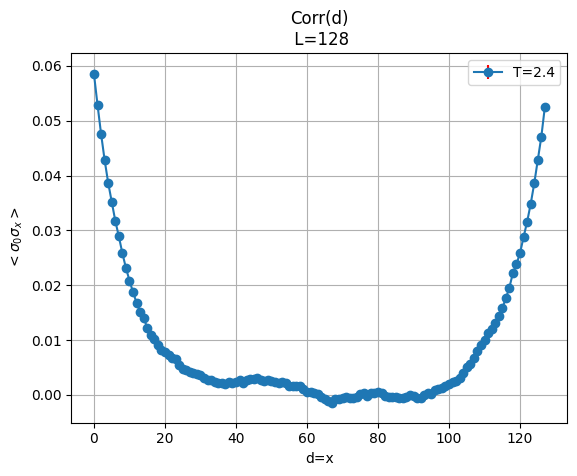

{'params': array([-1.94379697e-14,  9.99999999e-01]), 'vars': array([3.85623674e-26, 6.99009842e-16]), 'chi': 6.6532705212086535e+31}





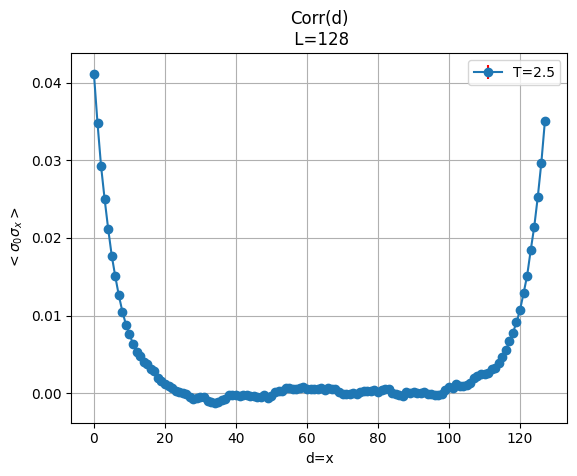

{'params': array([3.16335201e-14, 1.00000001e+00]), 'vars': array([9.84347313e-26, 1.43314221e-15]), 'chi': 3.305991740672043e+32}





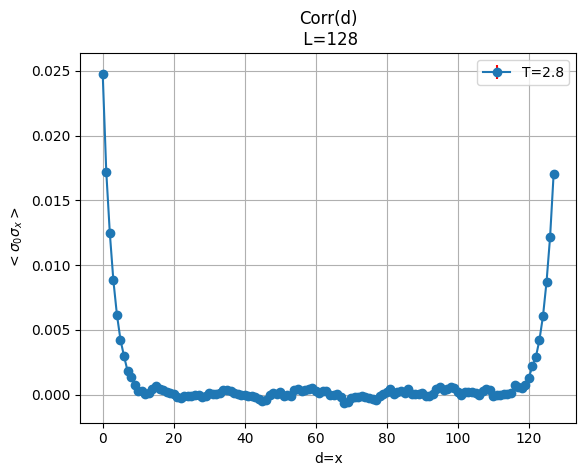

{'params': array([2.94806369e-14, 9.99999993e-01]), 'vars': array([7.67522106e-26, 2.35122922e-15]), 'chi': 8.030837328596684e+32}





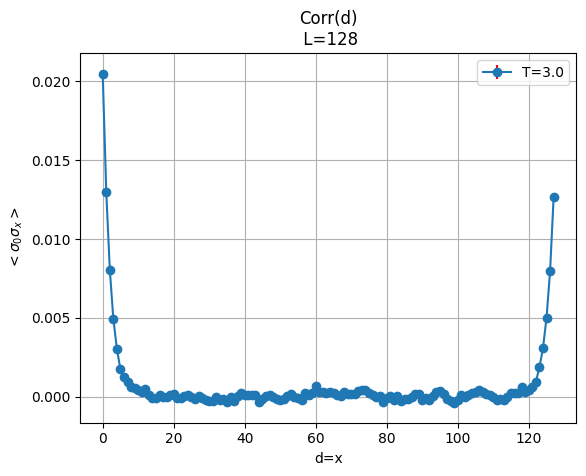

{'params': array([3.64830787e-14, 9.99999993e-01]), 'vars': array([1.16494249e-25, 1.73771385e-15]), 'chi': 1.847231579740785e+33}





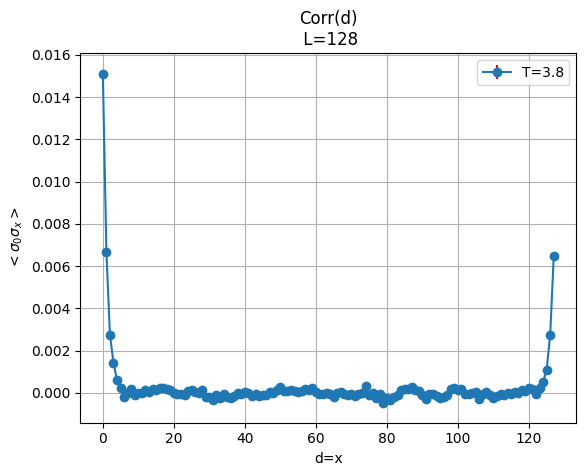

{'params': array([7.80485563e-14, 1.00000001e+00]), 'vars': array([5.08467403e-25, 1.08157630e-15]), 'chi': 1.6125701351868893e+34}





In [53]:
L=128
T_values = [2.4,2.5,2.8,3.0,3.8]

for T in T_values:
    

    dic = L_corr(T,L)

    def ansatz(x,a,b):
        return a*np.cosh((x-(L/2))/b)

    adjdic = adjust(dic["d"],dic["corr"],ansatz,dic["stderr"])
    xnew = np.linspace(dic["d"].min(),dic["d"].max(),500)

   # plt.plot(xnew,ansatz(xnew,*adjdic["params"]))

    plt.errorbar(dic["d"],dic["corr"],dic["stderr"],marker="o",ls="-",ecolor="r",label=f"{T=}")
    plt.title(f"Corr(d)\n {L=}")
    plt.xlabel("d=x")
    plt.ylabel("$<\sigma_0 \sigma_x>$")
    plt.legend()
    plt.grid()
    plt.show()
    print(adjdic)
    print("\n\n")

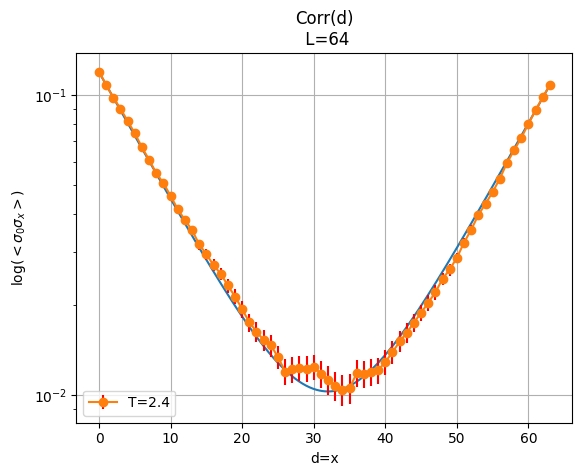

{'params': array([ 0.01031456, 10.20205387]), 'vars': array([2.10346012e-08, 3.06731605e-03]), 'chi': 0.9002599829933826}





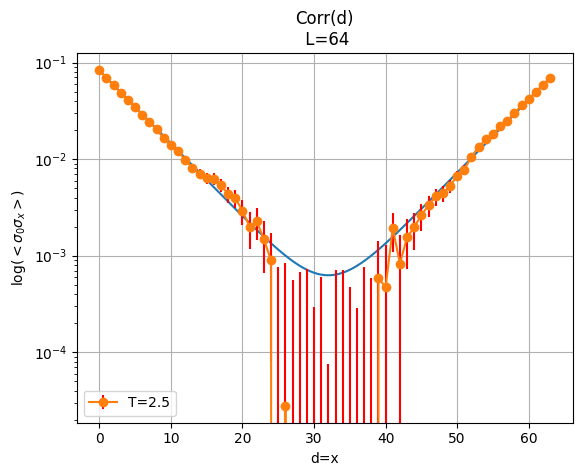

{'params': array([6.27108166e-04, 5.73661301e+00]), 'vars': array([6.75324915e-10, 2.22250952e-03]), 'chi': 0.899362696453502}





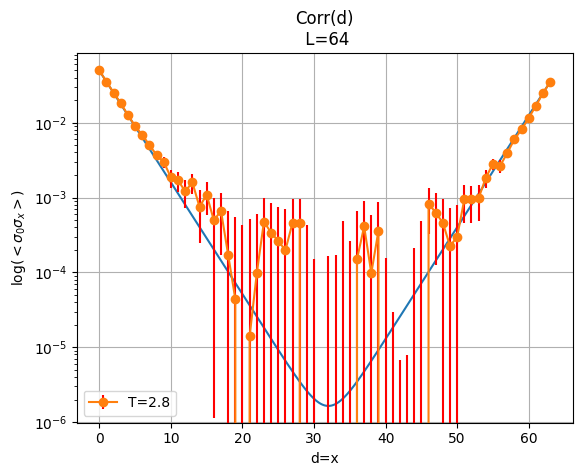

{'params': array([1.64438079e-06, 2.90710319e+00]), 'vars': array([3.80298362e-14, 1.08587434e-03]), 'chi': 0.8581704072357703}





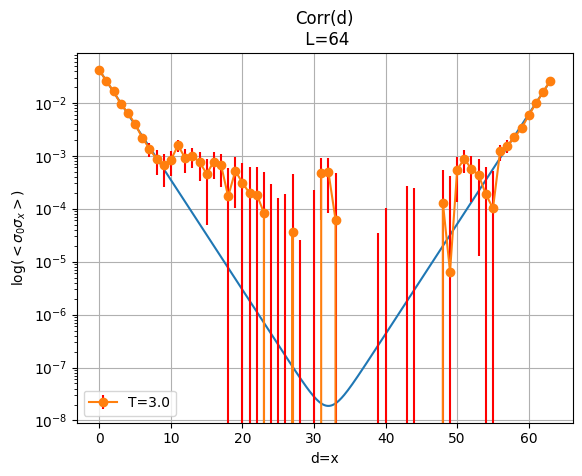

{'params': array([1.88173371e-08, 2.09175654e+00]), 'vars': array([1.89547341e-17, 1.07374858e-03]), 'chi': 1.2324871961007253}





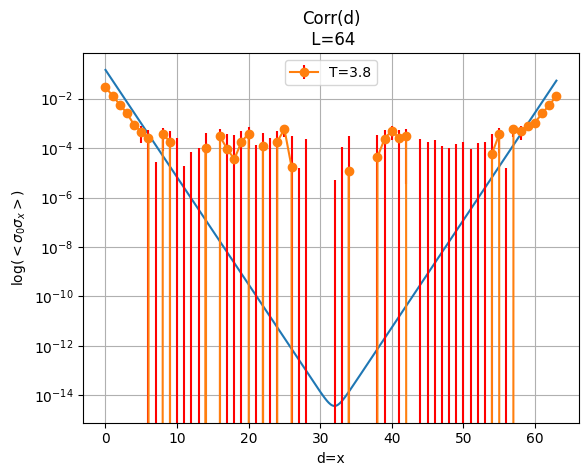

{'params': array([3.68003667e-15, 9.99999997e-01]), 'vars': array([3.52690978e-28, 1.17169368e-16]), 'chi': 1893.6864009054534}





In [20]:
L=64
T_values = [2.4,2.5,2.8,3.0,3.8]

for T in T_values:
    

    dic = L_corr(T,L)

    def ansatz(x,a,b):
        return a*np.cosh((x-(L/2))/b)

    adjdic = adjust(dic["d"],dic["corr"],ansatz,dic["stderr"])
    xnew = np.linspace(dic["d"].min(),dic["d"].max(),500)

    plt.plot(xnew,ansatz(xnew,*adjdic["params"]))

    plt.errorbar(dic["d"],dic["corr"],dic["stderr"],marker="o",ls="-",ecolor="r",label=f"{T=}")
    plt.title(f"Corr(d)\n {L=}")
    plt.xlabel("d=x")
    plt.ylabel("log($<\sigma_0 \sigma_x>$)")
    plt.yscale("log")
    plt.legend()
    plt.grid()
    plt.show()
    print(adjdic)
    print("\n\n")